In [13]:
import numpy as np
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cv2
plt.rcParams['figure.figsize'] = [4, 3]

### Introduction
A sunburst in photography occurs when light rays from a bright light source, such as the Sun, are captured by a camera's lens and aperture. They are created in photography by the apeture, a mechanism within the camera that controls the amount of light entering the lens when a photo is taken. When a small aperture setting is used, light passing through the lens diffracts around the edges of the aperture blades, causing the sunburst effect to be observed in images. We may think of the aperture as a narrow opening. When light passes through this small aperture, diffraction occurs, resulting in the distinctive starburst pattern observed in sunbursts captured through photography.

Sunburst are observed to have patterns in terms of their shapes. This study aims to quantitively find the relationship between an apeture and the diffration pattern it creates, and using the results to simulate the production of sunbursts.

## Background (Math and Physics)
### Light as Waves
In this scenario, we view light to behave as a wave. 
Description of wave:

$$f(t)=\sin(\omega t - kx)$$

The trignometric equation is a general discription of a wave's displacement as a function of time. $\omega$ is the angular frequency of the monochromatic light wave, $kx$ is the phase difference of the wave.

Below is a plot of the general sine function that describes light waves:

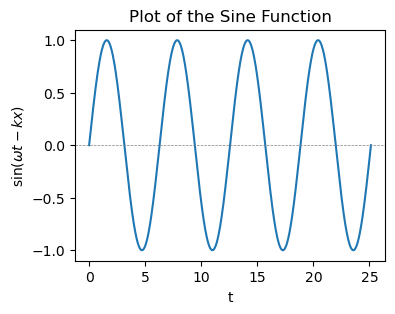

In [14]:
x = np.linspace(0, 8*np.pi, 1000)
y = np.sin(x)
plt.plot(x,y)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('t')
plt.ylabel('$\sin(\omega t - kx)$')
plt.title('Plot of the Sine Function')

plt.show()

The sine function equation describes the oscillatory nature of light waves as it propagates through space, which is the reason why diffraction patters can be seen with light waves passing through a small opening, like the camera's apeture.

### Single Slit Diffraction in Cameras
The apeture of the camera can be seen as a circle of single slits, at which light waves will superspose and form diffraction patterns. When single slit diffraction occurs, light waves superpose to form diffraction patterns that have a very central maximum. A plot of a single slit diffraction pattern is shown below:

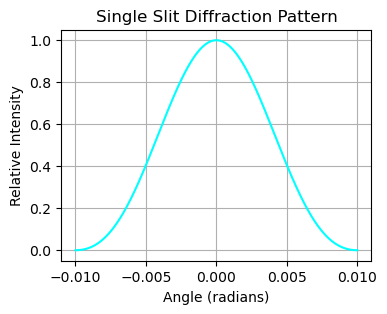

In [15]:
wavelength = 500e-9 
slit_width = 50e-6  
distance_to_screen = 1.0 

theta = np.linspace(-0.01, 0.01, 1000) 

beta = (np.pi * slit_width * np.sin(theta)) / wavelength
intensity = (np.sin(beta) / beta) ** 2
intensity[beta == 0] = 1 

plt.plot(theta, intensity, color='cyan')
plt.title("Single Slit Diffraction Pattern")
plt.xlabel("Angle (radians)")
plt.ylabel("Relative Intensity")
plt.grid(True)
plt.show()

### Fresnel diffraction integral

To predict the pattern formed by light after passing through such an aperture, we apply the Fresnel diffraction approximation, which models light intensity at a given distance from the aperture.
To calculate the diffraction pattern,
Diffraction intergral:

$$u(x,y)=A\frac{e^{jkz}}{z}\iint_A e^{\frac{jk}{2z}[(x-x_a)^2+(y-y_a)^2]}\,dx_a\,dy_a$$

In the formula,
$u(x,y)$ represents the amplitude of the light at point $(x,y)$ on the screen. $A$ is a constant that scales the amplitude. $\frac{e^{jkz}}{z}$ is a term that includes the propagation phase factor $e^{jkz}$ and its spreading effect over a distance of $z$. The double integral \( \iint_A \) over the aperture area  A  considers contributions from all points $(x_a,y_a)$ within the aperture. $e^{\frac{jk}{2z}[(x - x_a)^2 + (y - y_a)^2]}$ is the phase factor associated with each point within the aperture, capturing how distance from $(x_a,y_a)$ to  $(x,y)$  impacts the resulting wave.

This integral, known as the Fresnel diffraction integral, provides an approximation for the diffraction pattern produced by an aperture when observed at a finite distance.

## Simulation

### Model of apeture

First, the following function was defined to model a regular polygon with arbitary sides: (explain in terms of how real cameras work)

In [16]:
def create_polygon_mask(sides, size=(100, 100), center=None, radius=None):
    """
    Creating the polygon that represents the apeture
    
    Args:
        sides(int): number of sides of the intended polygon
        size(int, int): size of the whole plot
        center: centre of the polygon
        radius: radius of the polygon
        
    Returns
        a binary array that represents the polygon
    """
    # Set default center and radius if not provided
    if center is None:
        center = (size[0] // 2, size[1] // 2)
    if radius is None:
        radius = min(size) // 3

    # Calculate the vertices of the polygon
    theta = np.linspace(0, 2 * np.pi, sides, endpoint=False)
    vertices = np.stack((np.cos(theta), np.sin(theta)), axis=-1) * radius + center

    # Create a grid of points
    y, x = np.mgrid[:size[0], :size[1]]
    points = np.vstack((x.ravel(), y.ravel())).T

    # Create a path object and test each point
    path = mpath.Path(vertices)
    grid = path.contains_points(points)
    mask = grid.reshape(size)

    return mask

This is to replicate how apetures in actual camera lenses work: a few petals can be adjusted to form a near-circle in between them. This method makes the apeture size adjustable yet causes the starbust effect.

Secondly, we plot out the shape of the apeture alongside its predicted refraction pattern:

In [17]:
def graph_diffraction(mask, Z, lambda_, h):
    """
    Creating the simulation of the sunburst
    
    Returns
        the graph of the predicted sunburst pattern
    """
    A = np.fft.fft2(mask) #
    A = np.fft.fftshift(A) #...

    n1 = int(size[0]/2)
    u = np.arange(-n1, n1)
    v = np.arange(-n1, n1)
    
    U, V = np.meshgrid(u,v)
    
    propagator = np.exp(1j*2*np.pi*Z/h*np.sqrt((1/lambda_)**2-(U/h)**2-(V/h)**2))
    B = A * propagator
    output = np.abs(np.fft.ifft2(B))
    
    return output

Next, we can adjust the size, radius and other variables to plot the corresponding apetures and their diffracted fields:

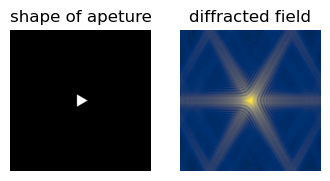

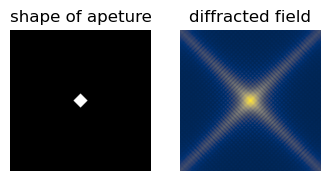

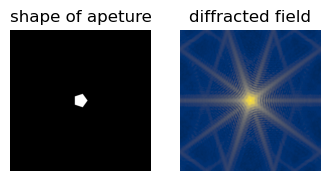

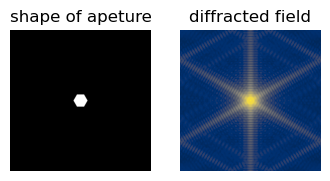

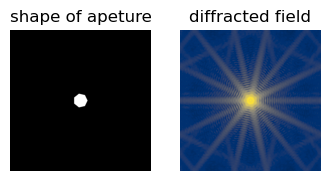

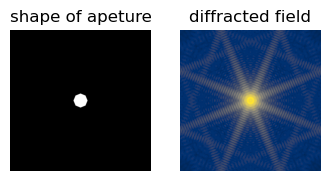

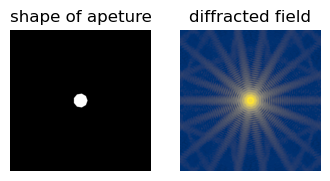

In [18]:
size = (2000, 2000) # size of our simulation
radius = 100 # 
Z = 500
lambda_ = 0.01
h = 15

sideList = np.arange(3, 10)

for side in sideList:
    mask = create_polygon_mask(side, size, None, radius)
    diffraction = graph_diffraction(mask, Z, lambda_, h)
    
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("shape of apeture")
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(diffraction+0.01), cmap='cividis')
    plt.axis('off')
    plt.title("diffracted field")
    

### Implement the FFT method to compare with experiment

Directly computing the diffraction integral mentioned before can be very complex. Thus, using the method introduced in *Numerical calculation of near field scalar diffraction using angular spectrum of plane waves theory and FFT*
(https://doi.org/10.48550/arXiv.1002.1999)(Adrian Carbajal-Dominguez et al., 2010), provides an efficient alternate algorithm for approximating diffraction patterns. This FFT-based method allows us to simulate the diffraction pattern easily, by transforming the aperture field into its angular spectrum, which can then be propagated and compared to actual results from experiments.

Three key procedures are introduced in this algorithm:
* First, compute the fourier transform of the input light.
* Then, measure the intensity of the input light at different points.
* Lastly, compare the intesnsity graphs of the actual and predicted patttern in a same graph.


# Experiment

We conduct the experiment with the following equipment:
    
* A small LED light with adjustable brightness
* A camera with adjustable focus
* A black cloth as the background

The camera’s exposure time was set through testing to find the right settings, to avoid overexposure of the light source while obtain a more accurate and clear diffraction pattern. The focus was adjusted manually through multiple trials, to ensure sharpness of the light rays captured. Additionally, the experiment was conducted in a dark environment before a dark backdrop to enhance the contrast between the light pattern, making the image as clear as possible.

One of the images obtained is as below:

<div>
<img src="_AIV8201.JPG" width="250"/>
</div>

We can notice that the sunburst in the photo is much stronger than our simulation, due to the camera unable to reflect the actual intensity of the light source. It is probably due to the light being so bright that it saturated the capacity of the camera's sensor in the middle region.

### Interpreting light intensity with a log function
This log function can explain the satuartion effect observed, In photography, the camera sensor's response to light intensity is not linear. As the intensity of light increases, the sensor's response curve becomes saturated, meaning that it reaches a point where further increases in light intensity result in smaller changes in recorded brightness. This behaviour is similar to the logarithmic function's curve, where rapid changes occur initially but rate of change slows down as the values increase.

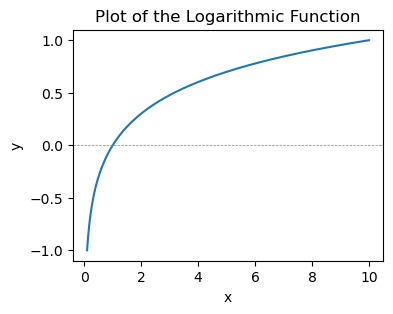

In [19]:
x = np.linspace(0.1, 10, 1000)
y = np.log10(x)

plt.plot(x, y, label='log(x)')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of the Logarithmic Function')

plt.show()

## Comparison of simulation and experiment
We pick one sunburst and plotted its intensity as a funtion of the distance to the centre, and compare it with the simulation.

The intensity and axes of both graphs were rescaled so that they would line up and be directly comparable to each other in shape. 

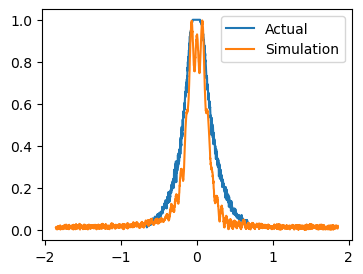

In [20]:
image = cv2.imread('Sunburst Exp Resize.JPG', cv2.IMREAD_GRAYSCALE)
image.shape

m = int(image.shape[0]/2)
n = int(size[0]/2)

a = image[m]
a = a / max(a)

b = diffraction / np.max(diffraction)
b = b[n]

x1 = np.linspace(-1, 1, image.shape[0]) /1.5
x2 = np.linspace(-1, 1, size[0]) / m * n

plt.plot(x1, a, label = "Actual")
plt.plot(x2, b, label = "Simulation")
plt.legend()


## Discussion
### Similarities and Differences between the Simulation and Experiment

The simulation and the experiment show highly coincident patterns, with both displaying a central bright region and surrounding diffraction patterns, confirming that the simulated model captures key features of the sunburst effect. However, the experimental pattern does show more variability in intensity and finer details that are not as sharp in the simulation.

### Factors Leading to Differences

The differences likely stem from simplifications in the simulation, such as idealizing the light source and aperture, and from limitations in the camera sensor, which may affect brightness levels. Real-world variables like ambient light and minor misalignments can also impact the experimental results, causing the real image captured.

### Strengths and Limitations

The simulation effectively models the general diffraction pattern and allows quick adjustments to test different parameters. However, it doesn’t fully replicate real-world conditions, as it overlooks factors like light source irregularities and limitations of the camera. While the model provides valuable insights, further refinement would improve its accuracy in matching experimental observations.